<a href="https://www.kaggle.com/code/melihkotman/bank-churn-xgboost-vs-rf-threshold-tuning?scriptVersionId=297223416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from keras.src.trainers.data_adapters.data_adapter_utils import class_weight_to_sample_weights
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravtopre/bank-customer-churn-dataset")

print("Path to dataset files:", path)

data = pd.read_csv(path + "/Bank Customer Churn Prediction.csv")
df = pd.DataFrame(data)
print(df.head(10))
print(df.columns)

Path to dataset files: /Users/melih/.cache/kagglehub/datasets/gauravtopre/bank-customer-churn-dataset/versions/1
   customer_id  credit_score  country  gender  age  tenure    balance  \
0     15634602           619   France  Female   42       2       0.00   
1     15647311           608    Spain  Female   41       1   83807.86   
2     15619304           502   France  Female   42       8  159660.80   
3     15701354           699   France  Female   39       1       0.00   
4     15737888           850    Spain  Female   43       2  125510.82   
5     15574012           645    Spain    Male   44       8  113755.78   
6     15592531           822   France    Male   50       7       0.00   
7     15656148           376  Germany  Female   29       4  115046.74   
8     15792365           501   France    Male   44       4  142051.07   
9     15592389           684   France    Male   27       2  134603.88   

   products_number  credit_card  active_member  estimated_salary  churn  
0        

# Exploratory Data Analysis – EDA (Keşifsel Veri Analizi)

Null value summary:
customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


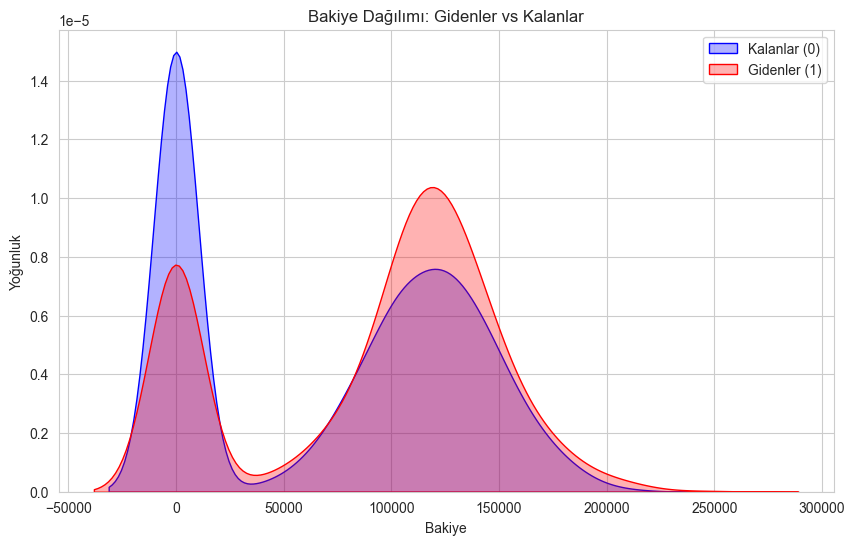

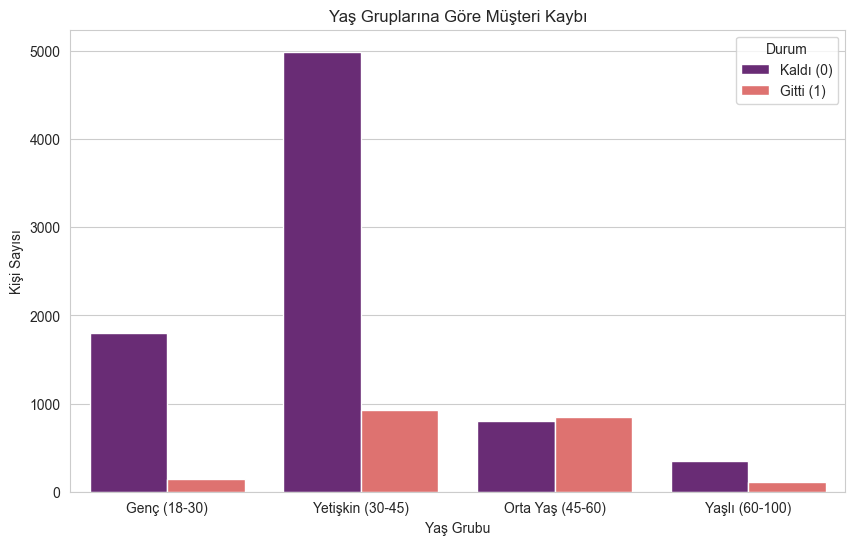

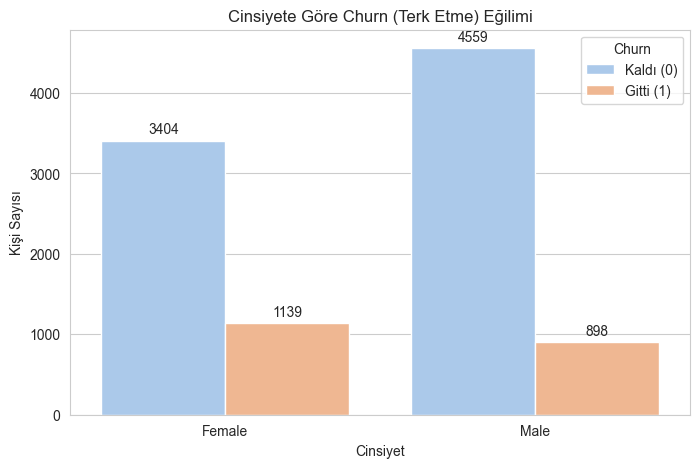

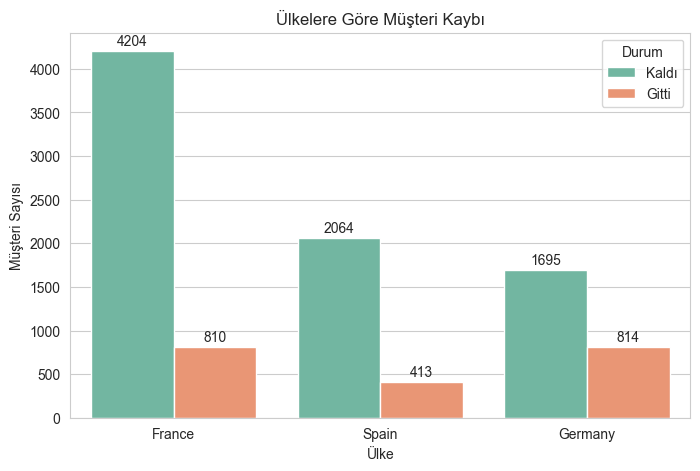

In [10]:
# Null Value Control
print("Null value summary:")
print(df.isnull().sum())


# Churn vs Balance
plt.figure(figsize=(10, 6))

# Churn = 0
sns.kdeplot(
    data = df[df['churn'] == 0],
    x = 'balance',
    fill = True, # Eğrinin altını boyar
    color = 'blue',
    label = 'Kalanlar (0)',
    alpha = 0.3
)

# Churn = 1
sns.kdeplot(
    data = df[df['churn'] == 1],
    x = 'balance',
    fill = True, # Eğrinin altını boyar
    color = 'red',
    label = 'Gidenler (1)', 
    alpha = 0.3
)

plt.title("Bakiye Dağılımı: Gidenler vs Kalanlar")
plt.xlabel("Bakiye")
plt.ylabel("Yoğunluk")
plt.legend()
plt.show()

# Age vs Churn
df['age_group'] = pd.cut(
    df['age'],
    bins = [18, 30, 45, 60, 100],
    labels = ['Genç (18-30)','Yetişkin (30-45)', 'Orta Yaş (45-60)', 'Yaşlı (60-100)']
) # cut ile birlikte sütundaki bilgiyi verilen bölüm aralıklarına ayırır ve gruplar

plt.figure(figsize=(10, 6))
sns.countplot(
    data = df,
    x = 'age_group',
    hue = 'churn', # Hedef değişken
    palette = 'magma'
)
plt.title("Yaş Gruplarına Göre Müşteri Kaybı")
plt.xlabel("Yaş Grubu")
plt.ylabel("Kişi Sayısı")
plt.legend(title='Durum', labels=["Kaldı (0)", "Gitti (1)"])
plt.show()


# Gender vs Churn
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data = df,
    x = 'gender',
    hue = 'churn', # Hedef değişken
    palette = 'pastel'
)

# Etiketleme (Kadın ve Erkek olarak kaç kişi gitmiş üzerine yazılsın)
for container in ax.containers:
    ax.bar_label(container, fmt = '%d', padding = 3) # Sayı formatı fmt ile belirlenir

plt.title("Cinsiyete Göre Churn (Terk Etme) Eğilimi")
plt.xlabel("Cinsiyet")
plt.ylabel("Kişi Sayısı")
plt.legend(title = "Churn", labels = ["Kaldı (0)", "Gitti (1)"])
plt.show()

# Country vs Churn
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data = df,
    x = 'country',
    hue = 'churn',
    palette = 'Set2'
)

# Etiketleme (Hangi ülkeden kaç kişi gitmiş üzerine yazılsın)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding = 2) # Sayı formatı fmt ile belirlenir

plt.title("Ülkelere Göre Müşteri Kaybı")
plt.xlabel("Ülke")
plt.ylabel("Müşteri Sayısı")
plt.legend(title='Durum', labels=["Kaldı", "Gitti"])
plt.show()

## Insights

###  Insights on Balance
* **Zero Balance Stability:** As seen in the KDE plot, a significant portion of customers with **0 balance** tends to stay (`Churn=0`). This might indicate inactive users or credit card-only users who are less likely to leave.
* **High Balance Risk:** Surprisingly, customers with a balance between **100k - 150k** show a higher tendency to churn. This could imply that customers with higher savings are more sensitive to interest rates or competitive offers from other banks.

### 💡 Insights on Age
* **Young & Adults:** The retention rate is higher among younger customers and adults.
* **Middle-Age Crisis:** There is a critical crossover point around **middle age (40-50s)** where the number of churners surpasses the number of retained customers. This suggests that the bank is losing its most financially mature audience.

### 💡 Insights on Gender
* **Proportionality:** While the dataset is somewhat balanced, **Female** customers show a slightly higher churn rate compared to **Males**.
* **Male Retention:** Men tend to stay with the bank more often than women. This might require a targeted marketing strategy for female customers.

### 💡 Insights on Geography
* **France & Spain:** These countries have relatively lower and stable churn rates.
* **The German Problem:** **Germany** exhibits a significantly higher churn rate compared to others. This is a major red flag. It could be due to local competition, lack of branch support, or specific dissatisfaction among German customers.

# XGBoost Modelling and Feature Engineering

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1607
           1       0.72      0.55      0.63       393

    accuracy                           0.87      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.86      0.87      0.86      2000



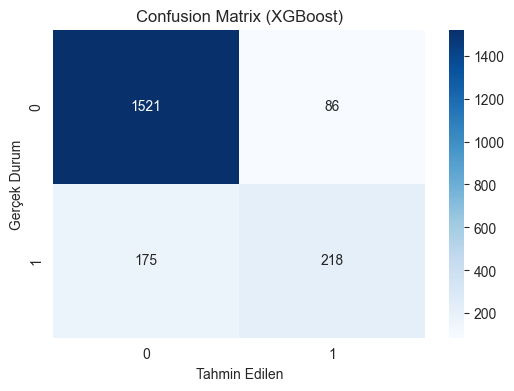

In [11]:
# X ve y değişkenlerine ayırıyoruz.
X = df.drop(['customer_id','churn', 'age_group'], axis = 1)
y = df['churn']

# Feature Engineering
# Country -> One-Hot Encoding
# Gender -> Label Encoding
X = pd.get_dummies(X, columns=['country'], drop_first = True) # drop_first = True ile dummy variable trap önlendi.

le = LabelEncoder()
X['gender'] = le.fit_transform(df['gender'])

# Train ve Test Ayırması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standard Scaler (Age, Balance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoosting
model = XGBClassifier(random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd', cmap = 'Blues')
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Durum")
plt.show()

The XGBoost model achieved an overall **Accuracy of 87%**, which looks promising at first glance. However, in churn prediction, accuracy can be misleading due to class imbalance (1607 retained vs. 393 churned customers).

##  Key Takeaways:
* **Strong on Retained Customers (Class 0):** The model identifies customers who stay with high precision (**0.90**) and recall (**0.95**).
* **The "Recall" Problem (Class 1):** The **Recall for Churners is only 0.55**.
    * **Business Impact:** This means the model captures only **55%** of the customers who are actually leaving. We are missing **45%** of the potential churners!
    * In a business context, missing a churner (False Negative) is often more costly than falsely flagging a loyal customer (False Positive).

# Random Forest with class_weight

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.78      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000



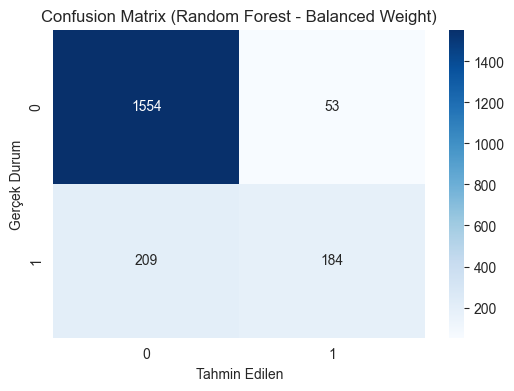

In [12]:
rf_weighted = RandomForestClassifier(
    n_estimators = 100,
    class_weight = 'balanced', # Sınıf dengesizliği için ağırlıklandırma
    random_state = 42
)

rf_weighted.fit(X_train, y_train)
y_pred_weighted = rf_weighted.predict(X_test)

print(classification_report(y_test, y_pred_weighted))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_weighted), annot = True, fmt = 'd', cmap = 'Blues')
plt.title("Confusion Matrix (Random Forest - Balanced Weight)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Durum")
plt.show()



We applied `class_weight='balanced'` to the Random Forest model to help it focus more on the minority class (Churners).

##  Key Observations:
* **Unexpected Drop in Recall:** Surprisingly, the **Recall for Churners dropped to 0.46** (lower than XGBoost's 0.55).
    * This indicates that simply adding class weights was not enough to make the model "aggressive" enough in detecting churners.
    * The model is prioritizing **Precision (0.77)** over Recall, meaning it is very careful not to make false alarms, but it misses more than half of the actual churners.

##  The Problem with Default Threshold (0.50)
Standard models use a **0.50 probability threshold** to classify a customer as "Churn".
* If Probability > 0.50 -> Churn
* If Probability < 0.50 -> Stay

However, for churn prediction, this is too conservative. We want to catch potential churners even if the probability is **30% or 40%**.

👉 **Solution: Threshold Moving:** We will manually adjust the decision threshold to increase Recall and capture those missed churners.

# Threshold Moving

--- Optimized Results (Threshold 0.35) ---
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.62      0.59      0.60       393

    accuracy                           0.85      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.85      0.85      0.85      2000



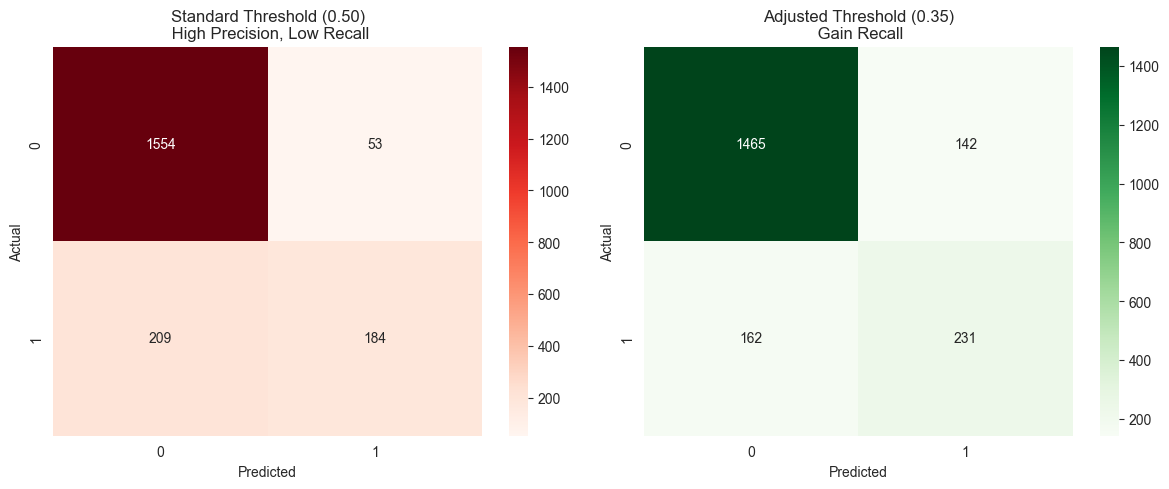

In [13]:
# Get Prediction Probabilities
# predict_proba -> [Leave_Rate, Stay_Rate], first index
y_pred_proba = rf_weighted.predict_proba(X_test)[:, 1]

# Apply New Threshold (0.35)
# Normal 0.5 -> 0.35
new_threshold = 0.35 # yüzde 35 ihtimal bile gidecek de
y_pred_new = (y_pred_proba >= new_threshold).astype(int)

# Compare Results
print(f"--- Optimized Results (Threshold {new_threshold}) ---")
print(classification_report(y_test, y_pred_new))

# Confusion matrix Comparison
plt.figure(figsize=(12, 5))

# Standard Confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_weighted), annot = True, fmt='d', cmap = 'Reds')
plt.title("Standard Threshold (0.50)\n High Precision, Low Recall")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_new), annot = True, fmt= 'd', cmap = 'Greens')
plt.title(f"Adjusted Threshold ({new_threshold})\n Gain Recall")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

By lowering the decision threshold from **0.50** to **0.35**, we successfully shifted the model's focus to capture more churners.

##  Comparative Results (Churn Class '1'):
* **Standard RF (0.50):** Recall = **0.46** (Missed more than half!)
* **Optimized RF (0.35):** Recall = **0.60** (Significant Improvement)

##  Business Impact:
*  **Gain:** We are now catching **60%** of the potential churners, compared to only 46% before. This allows the bank to take proactive measures (e.g., offering better rates) for a larger group of at-risk customers.
*  **Trade-off:** Precision dropped from **0.77** to **0.62**. This means we will make some "False Positive" calls (flagging loyal customers as churners). However, in customer retention strategies, sending a "Thank You" email or a small offer to a loyal customer is usually a safe and low-cost action compared to losing a valuable client.

##  Final Verdict
The **Random Forest model with Class Weighting and Threshold Tuning** provides the most actionable insights for the bank, striking a strategic balance between catching churners and maintaining reasonable accuracy.